In [1]:
import sys
sys.version

'3.5.2 (v3.5.2:4def2a2901a5, Jun 26 2016, 10:47:25) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]'

In [26]:
from sklearn.datasets import load_digits

In [27]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


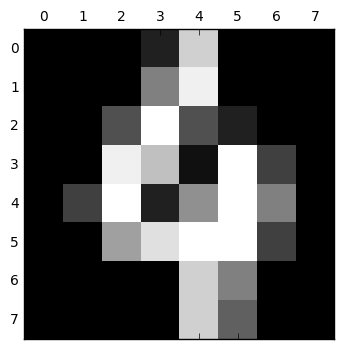

target: 4
target: 4


In [28]:
import matplotlib.pyplot as plt 
index = 100

plt.gray() 
plt.matshow(digits.images[index]) 
plt.show() 
print ("target:", digits.target[index])
print ("target:", digits.target_names[digits.target[index]])


In [29]:
from sklearn.model_selection import train_test_split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(digits.images, [0 if x%2==0 else 1 for x in digits.target], test_size=0.33, random_state=42)

In [30]:
print (X_train_orig.shape)

(1203, 8, 8)


In this case has "X_train_orig" shape like (1203, 8, 8) which means that there are 1203 examples of 8x8 images. I need to apply reshape because I would like to use logistic regression:
- $A = \sigma(w^T X + b)$
- error funcion $$ \mathcal{L}(a, y) =  - y  \log(a) - (1-y)  \log(1-a)$$
- cost function $$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$ which can be rewritten to $$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$$
- $\sigma$ is sigmoid function $$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$

Because of $w^T X$ I need  $w$ to have shape $(8*8,1)$ and therefore $X$ has to be shape $(8*8,-1)$

The error funcion $ \mathcal{L}(a, y) =  - y  \log(a) - (1-y)  \log(1-a)$ is chosen because when:
- true label is 0 then $ \mathcal{L}(a, y) = - (1-y)  \log(1-a)$ and to minimaze this we need $(1-a)$ to be large therefore $a$ to be small (close to 0)
- true label is 1 then $ \mathcal{L}(a, y) = - y  \log(a)$ and to minimaze this we need $(a)$ to be large therefore $a$ to be large (close to 1)

In [31]:
import numpy as np

X_train = X_train_orig.reshape(-1 , X_train_orig.shape[1] * X_train_orig.shape[2]).T
X_test = X_test_orig.reshape(-1, X_test_orig.shape[1] * X_test_orig.shape[2]).T
y_train = np.array(y_train_orig).reshape(1,-1)
y_test = np.array(y_test_orig).reshape(1,-1)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(64, 1203)
(64, 594)
(1, 1203)
(1, 594)


In [33]:
digits.images[0]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

In [34]:
X_train[:,0]

array([  0.,   0.,   0.,   1.,  12.,   7.,   0.,   0.,   0.,   0.,   0.,
         9.,  16.,  16.,   1.,   0.,   0.,   1.,   7.,  15.,  16.,  14.,
         0.,   0.,   0.,   4.,  16.,  16.,  16.,  16.,   0.,   0.,   0.,
         0.,   0.,   3.,  16.,  16.,   0.,   0.,   0.,   0.,   0.,   2.,
        16.,  16.,   3.,   0.,   0.,   0.,   0.,   6.,  16.,  16.,   0.,
         0.,   0.,   0.,   0.,   3.,  15.,  13.,   0.,   0.])

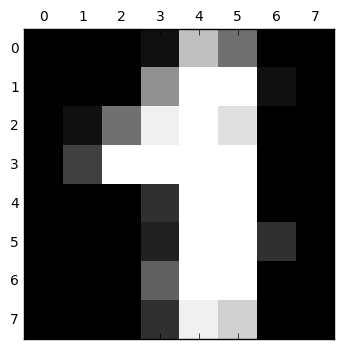

In [35]:
plt.gray() 
plt.matshow(X_train[:,0].reshape(8,8)) 
plt.show() 

<img src="img/logistic_regression_graph.png"/>

To calculated derivative $dw$ and $db$ we need to use calsulus:
$$ \frac{\partial L}{\partial w^{(i)}} = x^{(i)} * \frac{\partial L}{\partial z^{(i)}} = x^{(i)} * \frac{\partial L}{\partial a^{(i)}} * \frac{\partial a^{(i)}}{\partial z^{(i)}}$$
- because of derivative of composite function

$$ \frac{\partial L}{\partial z^{(i)}} = \frac{\partial L}{\partial a^{(i)}} * \frac{\partial a^{(i)}}{\partial z^{(i)}} = (- \frac{y^{(i)}}{a^{(i)}} + \frac{(1-y^{(i)})}{(1-a^{(i)})}) * (a^{(i)} * (1 - a^{(i)})) = a^{(i)} - y^{(i)}$$


We can vectorize error function and transform into:
$$ \frac{\partial L}{\partial z} = (A-Y)$$

and for cost function we get:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [79]:
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.w = np.zeros((self.X_train.shape[0], 1))
        self.b = 0.0
        self.m = X_train.shape[1]
        
    def sigmoid(self, z):
        return 1.0 / (1 + np.exp(-z))

    def sigmoid_derivate(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def propagate(self, w, b, X, Y):
        # math is shown above
        A = self.sigmoid(np.dot(w.T, X) + b)
        cost = - 1.0/self.m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

        # how big mistake is in the certain part of w with respect to Cost function
        dw = 1/self.m * np.dot(X, (A - Y).T)
        db = 1/self.m * np.sum(A - Y)

        results = {"dw": dw,
                   "db": db,
                   "cost": cost}

        return results

    def optimize(self, w, b, X, Y, learning_rate, num_iteration):
        # good for logging and plotting graph
        costs = []

        for i in range(num_iteration):
            propagation = self.propagate(w, b, X, Y)
            costs.append(propagation["cost"])

            w = w - learning_rate * propagation["dw"]
            b = b - learning_rate * propagation["db"]

        results = {"w": w,
                   "b": b,
                   "costs": costs}

        return results

    def _predict(self, w, b, X, treshold = 0.5):
        A = self.sigmoid(np.dot(w.T, X) + b)
        return np.array([1 if x >= treshold else 0 for x in A[0]]).reshape(1,-1)    
        
    def train(self, learning_rate, num_iteration):
        self.learning_rate = learning_rate
        self.num_iteration = num_iteration
        
        results = self.optimize(self.w, self.b, self.X_train, self.y_train, learning_rate, num_iteration)
        self.costs = results["costs"]
        self.w = results["w"]
        self.b = results["b"]
    
    def test(self):
        prediction = self._predict(self.w, self.b, self.X_test)
        return float(100 - np.mean(np.abs(prediction - self.y_test)) * 100)
    
    def predict(self, example):
        return self._predict(self.w, self.b, example)
    
    def show_cost_curve(self):
        import matplotlib.pyplot as plt 
        plt.plot(self.costs)
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(self.learning_rate) + "\nIteration =" + str(self.num_iteration))
        plt.show()

In [67]:
regression = LogisticRegression(X_train, y_train, X_test, y_test)
regression.train(0.001, 1000)
print (regression.test() , "%")

93.26599326599327 %


In [ ]:
example = X_train[:,10].reshape(8*8,1)
# show image
plt.gray() 
plt.matshow(example.reshape(8,8)) 
plt.show() 
# give prediction
print ("is the number on the picture odd:" , bool(regression.predict(example)))

In [ ]:
regression.show_cost_curve()

# Other examples

In [68]:
import sklearn.datasets
import numpy as np
from sklearn.model_selection import train_test_split

N = 300
noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)

In [69]:
X_moons_all = np.array(noisy_moons[0])
Y_moons_all = np.array(noisy_moons[1])

In [70]:
X_moons_all.shape

(300, 2)

In [71]:
Y_moons_all.shape

(300,)

In [72]:
np.prod([x for x in X_train_moons.shape[1:]])

201

In [73]:
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons_all, Y_moons_all, test_size=0.33, random_state=42)

X_train_moons = X_train_moons.reshape(-1 , X_train_moons.shape[1]).T
X_test_moons = X_test_moons.reshape(-1, X_test_moons.shape[1]).T
y_train_moons = np.array(y_train_moons).reshape(1,-1)
y_test_moons = np.array(y_test_moons).reshape(1,-1)

print (X_train_moons.shape)
print (X_test_moons.shape)
print (y_train_moons.shape)
print (y_test_moons.shape)

regression = LogisticRegression(X_train_moons, y_train_moons, X_test_moons, y_test_moons)
regression.train(0.001, 1000)
print (regression.test() , "%")

(2, 201)
(2, 99)
(1, 201)
(1, 99)
84.84848484848484 %


In [98]:
def plot_decision_boundary(model, X, y):    
    assert(X.shape == (2, X.shape[1]))
    assert(y.shape == (1, y.shape[1]))

    import matplotlib.pyplot as plt 
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    
    # can hardcode reshaping because there is assert control
    Z = np.array([model.predict(np.array(x).reshape(2,1)) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

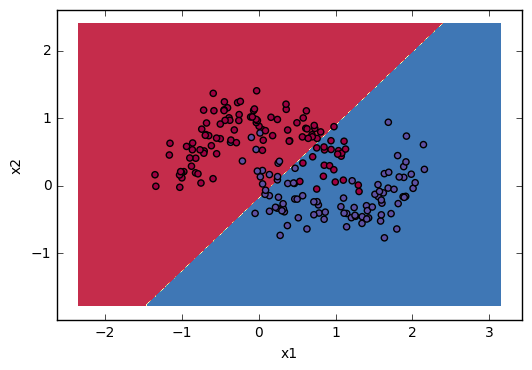

In [99]:
plot_decision_boundary(model = regression, X = X_train_moons, y = y_train_moons)

In [100]:
N = 400
noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    
X_circles_all = np.array(noisy_circles[0])
Y_circles_all = np.array(noisy_circles[1])

X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X_circles_all, Y_circles_all, test_size=0.33, random_state=42)

X_train_circles = X_train_circles.reshape(-1 , X_train_circles.shape[1]).T
X_test_circles = X_test_circles.reshape(-1, X_test_circles.shape[1]).T
y_train_circles = np.array(y_train_circles).reshape(1,-1)
y_test_circles = np.array(y_test_circles).reshape(1,-1)

print (X_train_circles.shape)
print (X_test_circles.shape)
print (y_train_circles.shape)
print (y_test_circles.shape)

regression = LogisticRegression(X_train_circles, y_train_circles, X_test_circles, y_test_circles)
regression.train(0.001, 1000)
print (regression.test() , "%")

(2, 268)
(2, 132)
(1, 268)
(1, 132)
46.96969696969697 %


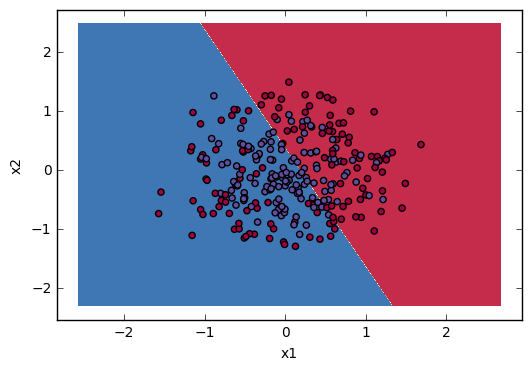

In [102]:
plot_decision_boundary(model = regression, X = X_train_circles, y = y_train_circles)

# Resources
- https://www.coursera.org/learn/neural-networks-deep-learning
- http://ronny.rest/blog/post_2017_08_12_logistic_regression_derivative/
- 